In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#pip install mediapipe 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 1.4 MB/s 


In [3]:
import numpy as np
import os
import scipy.io as sio
import cv2
import math
from math import cos, sin
import dlib
import mediapipe
import glob
from pathlib import Path
import pandas as pd
from PIL import Image, ImageFilter
from google.colab.patches import cv2_imshow
import scipy.io
from random import randint
import moviepy.video.io.ImageSequenceClip
import re
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import time

In [5]:
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
To: /content/AFLW2000-3D.zip
100% 87.4M/87.4M [00:01<00:00, 75.6MB/s]
Archive:  /content/AFLW2000-3D.zip
   creating: AFLW2000/
   creating: AFLW2000/Code/
  inflating: AFLW2000/Code/DrawSolidHead.m  
  inflating: AFLW2000/Code/DrawTextureHead.m  
  inflating: AFLW2000/Code/main_show_without_BFM.m  
  inflating: AFLW2000/Code/main_show_with_BFM.m  
   creating: AFLW2000/Code/Mex/
  inflating: AFLW2000/Code/Mex/compile.m  
  inflating: AFLW2000/Code/Mex/Tnorm_Vnorm.h  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.cpp  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.mexw64  
   creating: AFLW2000/Code/ModelGeneration/
  inflating: AFLW2000/Code/ModelGeneration/ModelGenerate.m  
  inflati

In [119]:
mylist = sorted([Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")])

In [120]:
from imutils import face_utils

p = "/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

In [121]:
def get_list_from_filenames(file_path):
    # input:    relative path to .txt file with file names
    # output:   list of relative path names
    lines = [Path(f).stem for f in glob.glob(file_path)]
    return lines

In [122]:
def get_pt2d_from_mat(mat_path):
    # Get 2D landmarks
    mat = sio.loadmat(mat_path)
    pt2d = mat['pt2d']
    return pt2d

In [123]:
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]

    return pose_params

In [124]:
class AFLW2000():
    def __init__(self, data_dir,file_path, img_ext='.jpg', annot_ext='.mat', image_mode='RGB'):
        self.data_dir = data_dir
        self.file_path = file_path
        self.img_ext = img_ext
        self.annot_ext = annot_ext

        filename_list = get_list_from_filenames(data_dir)
        filename_list.sort()
        self.X_train = filename_list
        self.y_train = filename_list
        self.image_mode = image_mode
        self.length = len(filename_list)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.file_path,self.X_train[index] + self.img_ext))
        img = img.convert(self.image_mode)
        mat_path = os.path.join(self.file_path,self.y_train[index] + self.annot_ext)
        # Crop the face loosely
        pt2d = get_pt2d_from_mat(mat_path)

      
        x_min = min(pt2d[0,:])
        y_min = min(pt2d[1,:])
        x_max = max(pt2d[0,:])
        y_max = max(pt2d[1,:])

        k = 0.20
        x_min -= 2 * k * abs(x_max - x_min)
        y_min -= 2 * k * abs(y_max - y_min)
        x_max += 2 * k * abs(x_max - x_min)
        y_max += 0.6 * k * abs(y_max - y_min)
        
        img = img.crop((int(x_min), int(y_min), int(x_max), int(y_max)))

        # We get the pose in radians
        pose = get_ypr_from_mat(mat_path)
        
        pitch = pose[0]
        yaw = pose[1] 
        roll = pose[2] 
        
        labels = [pitch, yaw, roll]
        # if self.transform is not None:
        #     img = self.transform(img)
        # return cont_labels
        return img, labels, self.X_train[index]

    def __len__(self):
        # 2,000
        return self.length


In [125]:
demo=AFLW2000("/content/AFLW2000/*.mat",'/content/AFLW2000/')

In [126]:
labels=[]
imgs=[]

for i in range(len(mylist)):
  pla=demo.__getitem__(i)
  x = np.array(pla[1], dtype=np.float32)
  labels.append(x)
  imgs.append(pla[2])


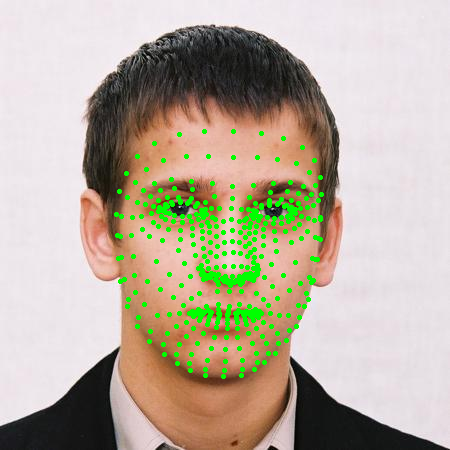

In [127]:
random_file = 'image00053'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

In [128]:
features = pd.DataFrame(np.ones((len(mylist),936)))
faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    for ind,l in enumerate(mylist):
      image = cv2.imread('/content/AFLW2000/'+l+'.jpg')
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
      # looping over the faces in the image
        x_axis = []
        y_axis = []
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                x_axis.append(relative_x)
                y_axis.append(relative_y)

      x_axis_ = np.array(x_axis) - x_axis[333]
      y_axis_ = np.array(y_axis) - y_axis[333]
      x2 = x_axis[200]
      x1 = x_axis[0]
      y2 = y_axis[200]
      y1 = y_axis[0]
      dist = pow(pow((x2-x1),2)+pow((y2-y1),2),0.5)
      x_axis = np.array(x_axis_)/dist
      y_axis = np.array(y_axis_)/dist
      data = np.hstack((x_axis,y_axis))
      features.iloc[ind] = data  

In [129]:
labels = np.array(labels, dtype=np.float32)
labels = pd.DataFrame(labels,columns=['pitch', 'yaw', 'roll']) #convert to a dataframe

In [130]:
df = pd.concat([features, labels],axis = 1)

In [131]:
df['img']=imgs

In [132]:
df.to_csv("testfile",index=False) #save to file

#Then, to reload:
df = pd.read_csv("testfile")

In [133]:
features_cols = list(features.columns) 
label = ['pitch'	,'yaw'	,'roll']
X = pd.concat([features, df['img']],axis = 1)
y = df[label]

In [134]:
drop_duplicates = list(features[features.duplicated() ==  True].index)

In [135]:
X.drop(drop_duplicates, axis=0, inplace=True)
y.drop(drop_duplicates, axis=0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [136]:
X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40)

In [137]:
X_train = X_train_[features_cols]
X_test = X_test_[features_cols]

In [138]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
count,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,...,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000
mean,-1.267623,-1.278774,-1.271721,-1.419270,-1.280756,-1.281070,-1.277206,-2.470129,-1.279607,-1.282146,...,2.394800,2.329987,2.415010,2.416741,2.450688,1.115501,1.175379,1.221502,0.984774,0.904730
std,0.871298,0.884688,0.790354,0.727126,0.870145,0.795778,0.575898,0.757589,0.496670,0.492975,...,0.658786,0.641184,0.597028,0.671170,0.663797,0.329180,0.358076,0.382837,0.206088,0.195097
min,-4.481374,-4.054577,-4.146033,-3.627779,-3.902149,-3.658265,-2.987583,-5.130484,-2.833490,-2.833490,...,-2.150224,-2.104956,-2.195492,-2.172858,-2.218126,-1.044560,-1.124910,-1.178477,-0.995893,-0.863604
25%,-1.757132,-1.819956,-1.733485,-1.876024,-1.828094,-1.789123,-1.643563,-2.982198,-1.594856,-1.601616,...,2.017710,1.957987,2.072255,2.033943,2.071229,0.923788,0.962424,0.998740,0.861736,0.790380
50%,-1.336778,-1.378281,-1.336347,-1.525568,-1.394424,-1.386556,-1.359432,-2.505491,-1.344322,-1.358928,...,2.372515,2.313079,2.399081,2.392010,2.430570,1.114522,1.174086,1.216448,0.995835,0.915168
75%,-0.806471,-0.794389,-0.835056,-1.019912,-0.814453,-0.848875,-0.962043,-1.951932,-1.023533,-1.035119,...,2.801010,2.722802,2.788282,2.828267,2.862892,1.321503,1.401286,1.461446,1.113766,1.030407
max,3.698190,2.942036,3.137858,2.213311,2.711288,2.381410,1.652979,2.195492,1.430344,1.376369,...,4.921182,4.759301,4.500291,4.985934,4.985934,2.395838,2.622472,2.784353,1.565968,1.444543


AdaBoost

In [139]:
"""
start = time.time()
print("hello")

scores_ada = []
models = []

max_depth = [3,20,25,40]
n_estimators = [50,75,100,120]
learning_rate = [0.01,0.1,1]
score0 = 1000
score1 = 1000
score2 = 1000
AdaBoost_winner0 = AdaBoostRegressor(random_state=0)
AdaBoost_winner1 = AdaBoostRegressor(random_state=0)
AdaBoost_winner2 = AdaBoostRegressor(random_state=0)
AdaBoost_winner0.fit(X_train,y_train.iloc[:,0].values)
AdaBoost_winner1.fit(X_train,y_train.iloc[:,1].values)
AdaBoost_winner2.fit(X_train,y_train.iloc[:,2].values)
o = 0
for n in n_estimators:
  for l in learning_rate:
    for m in max_depth:
      print(o)
      o = o+1
      AdaBoost0 = AdaBoostRegressor(base_estimator = tree.DecisionTreeRegressor(max_depth=m),n_estimators = n,learning_rate = l,random_state=0)
      AdaBoost0.fit(X_train,y_train.iloc[:,0].values)
      ypred = AdaBoost0.predict(X_valid)
      if mean_squared_error(ypred, pd.DataFrame(y_valid.iloc[:,0]).values, squared=False) < score0:
        AdaBoost_winner0 = AdaBoost0
        score0 = mean_squared_error(ypred, pd.DataFrame(y_valid.iloc[:,0]).values, squared=False)
      
      AdaBoost1 = AdaBoostRegressor(base_estimator = tree.DecisionTreeRegressor(max_depth=m),n_estimators = n,learning_rate = l,random_state=0)
      AdaBoost1.fit(X_train,y_train.iloc[:,1].values)
      ypred = AdaBoost1.predict(X_valid)
      if mean_squared_error(ypred, pd.DataFrame(y_valid.iloc[:,1]).values, squared=False) < score1:
        AdaBoost_winner1 = AdaBoost1
        score1 = mean_squared_error(ypred, pd.DataFrame(y_valid.iloc[:,1]).values, squared=False)

      AdaBoost2 = AdaBoostRegressor(base_estimator = tree.DecisionTreeRegressor(max_depth=m),n_estimators = n,learning_rate = l,random_state=0)
      AdaBoost2.fit(X_train,y_train.iloc[:,2].values)
      ypred = AdaBoost2.predict(X_valid)
      if mean_squared_error(ypred, pd.DataFrame(y_valid.iloc[:,2]).values, squared=False) < score2:
        AdaBoost_winner2 = AdaBoost2
        score2 = mean_squared_error(ypred, pd.DataFrame(y_valid.iloc[:,2]).values, squared=False)

scores_ada.append(score0)
models.append(AdaBoost_winner0)
scores_ada.append(score1)
models.append(AdaBoost_winner1)
scores_ada.append(score2)
models.append(AdaBoost_winner2)

end = time.time()
print('finished',end - start)
"""

'\nstart = time.time()\nprint("hello")\n\nscores_ada = []\nmodels = []\n\nmax_depth = [3,20,25,40]\nn_estimators = [50,75,100,120]\nlearning_rate = [0.01,0.1,1]\nscore0 = 1000\nscore1 = 1000\nscore2 = 1000\nAdaBoost_winner0 = AdaBoostRegressor(random_state=0)\nAdaBoost_winner1 = AdaBoostRegressor(random_state=0)\nAdaBoost_winner2 = AdaBoostRegressor(random_state=0)\nAdaBoost_winner0.fit(X_train,y_train.iloc[:,0].values)\nAdaBoost_winner1.fit(X_train,y_train.iloc[:,1].values)\nAdaBoost_winner2.fit(X_train,y_train.iloc[:,2].values)\no = 0\nfor n in n_estimators:\n  for l in learning_rate:\n    for m in max_depth:\n      print(o)\n      o = o+1\n      AdaBoost0 = AdaBoostRegressor(base_estimator = tree.DecisionTreeRegressor(max_depth=m),n_estimators = n,learning_rate = l,random_state=0)\n      AdaBoost0.fit(X_train,y_train.iloc[:,0].values)\n      ypred = AdaBoost0.predict(X_valid)\n      if mean_squared_error(ypred, pd.DataFrame(y_valid.iloc[:,0]).values, squared=False) < score0:\n      

Decision Tree

In [140]:
"""
start = time.time()
print("hello")
scores_tree = []
models_tree = []

max_depth = [3,25,40,None]
max_leaf_nodes = [10,20,None]
min_samples_split = [2,5,10,20,100]
score0_tree = 100
score1_tree = 100
score2_tree = 100
tree_winner0 = tree.DecisionTreeRegressor(random_state=0)
tree_winner1 = tree.DecisionTreeRegressor(random_state=0)
tree_winner2 = tree.DecisionTreeRegressor(random_state=0)
tree_winner0.fit(X_train,y_train.iloc[:,0].values)
tree_winner1.fit(X_train,y_train.iloc[:,1].values)
tree_winner2.fit(X_train,y_train.iloc[:,2].values)
i = 0
for n in max_leaf_nodes:
  for s in min_samples_split:
    for m in max_depth:
      print(i)
      i = i + 1
      tree0 = tree.DecisionTreeRegressor(max_depth = m,max_leaf_nodes = n,min_samples_split=s,random_state=0)
      tree0.fit(X_train,y_train.iloc[:,0].values)
      ypred = tree0.predict(X_valid)
      if mean_squared_error(ypred, pd.DataFrame(y_valid.iloc[:,0]).values, squared=False) < score0_tree:
        tree_winner0 = tree0
        score0_tree = mean_squared_error(ypred, pd.DataFrame(y_valid.iloc[:,0]).values, squared=False)

      tree1 = tree.DecisionTreeRegressor(max_depth = m,max_leaf_nodes = n,min_samples_split=s,random_state=0)
      tree1.fit(X_train,y_train.iloc[:,1].values)
      ypred = tree1.predict(X_valid)
      if mean_squared_error(ypred, pd.DataFrame(y_valid.iloc[:,1]).values, squared=False) < score1_tree:
        tree_winner1 = tree1
        score1_tree = mean_squared_error(ypred, pd.DataFrame(y_valid.iloc[:,1]).values, squared=False)

      tree2 = tree.DecisionTreeRegressor(max_depth = m,max_leaf_nodes = n,min_samples_split=s,random_state=0)
      tree2.fit(X_train,y_train.iloc[:,2].values)
      ypred = tree2.predict(X_valid)
      if mean_squared_error(ypred, pd.DataFrame(y_valid.iloc[:,2]).values, squared=False) < score2_tree:
        tree_winner2 = tree2
        score2_tree = mean_squared_error(ypred, pd.DataFrame(y_valid.iloc[:,2]).values, squared=False)

scores_tree.append(score0_tree)
models_tree.append(tree_winner0)
scores_tree.append(score1_tree)
models_tree.append(tree_winner1)
scores_tree.append(score2_tree)
models_tree.append(tree_winner2)

end = time.time()
print(end - start)
"""

'\nstart = time.time()\nprint("hello")\nscores_tree = []\nmodels_tree = []\n\nmax_depth = [3,25,40,None]\nmax_leaf_nodes = [10,20,None]\nmin_samples_split = [2,5,10,20,100]\nscore0_tree = 100\nscore1_tree = 100\nscore2_tree = 100\ntree_winner0 = tree.DecisionTreeRegressor(random_state=0)\ntree_winner1 = tree.DecisionTreeRegressor(random_state=0)\ntree_winner2 = tree.DecisionTreeRegressor(random_state=0)\ntree_winner0.fit(X_train,y_train.iloc[:,0].values)\ntree_winner1.fit(X_train,y_train.iloc[:,1].values)\ntree_winner2.fit(X_train,y_train.iloc[:,2].values)\ni = 0\nfor n in max_leaf_nodes:\n  for s in min_samples_split:\n    for m in max_depth:\n      print(i)\n      i = i + 1\n      tree0 = tree.DecisionTreeRegressor(max_depth = m,max_leaf_nodes = n,min_samples_split=s,random_state=0)\n      tree0.fit(X_train,y_train.iloc[:,0].values)\n      ypred = tree0.predict(X_valid)\n      if mean_squared_error(ypred, pd.DataFrame(y_valid.iloc[:,0]).values, squared=False) < score0_tree:\n        

SVR

In [141]:
svr_paras = {'kernel':['poly', 'rbf','sigmoid'],
             'C':[0.01,0.1,1,100]}
svr_wi0 = GridSearchCV(estimator = SVR(),param_grid = svr_paras)
svr_wi1 = GridSearchCV(estimator = SVR(),param_grid = svr_paras)
svr_wi2 = GridSearchCV(estimator = SVR(),param_grid = svr_paras)
svr_wi0.fit(X_train, y_train.iloc[:,0].values)
svr_wi1.fit(X_train, y_train.iloc[:,1].values)
svr_wi2.fit(X_train, y_train.iloc[:,2].values)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1, 100],
                         'kernel': ['poly', 'rbf', 'sigmoid']})

In [142]:
print(svr_wi0.best_estimator_ ,svr_wi1.best_estimator_,svr_wi2.best_estimator_)

SVR(C=100, kernel='poly') SVR(C=1) SVR(C=1)


In [143]:
svr_winner0 = svr_wi0.best_estimator_
svr_winner1 = svr_wi1.best_estimator_
svr_winner2 = svr_wi2.best_estimator_

draw axis on test data (random sample)

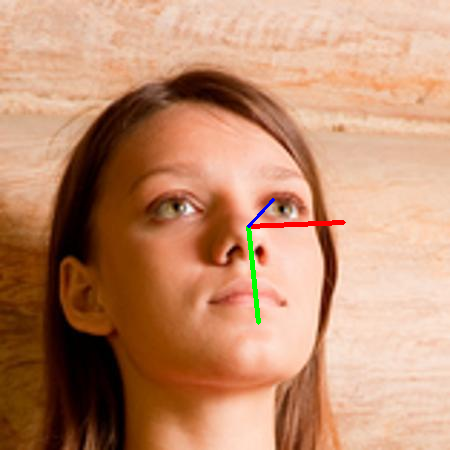

In [163]:
def draw_random_img_axis(X_test,X_test_,location):

  ind = randint(0, X_test.shape[0]-1)
  try_test_ = pd.DataFrame(X_test_.values, index=None)
  try_test = pd.DataFrame(X_test.values, index=None)
  test_eg = try_test.iloc[[ind]]
  test_eg_img = try_test_.iloc[ind,936]
  test_draw_pitch = svr_winner0.predict(test_eg)
  test_draw_yaw = svr_winner1.predict(test_eg)
  test_draw_roll = svr_winner2.predict(test_eg)
  image_draw = location+test_eg_img+'.jpg'
  frame = cv2.imread(image_draw)
  cv2_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
  return cv2_frame,frame,test_draw_yaw,test_draw_pitch ,test_draw_roll

cv2_frame,frame,test_draw_yaw,test_draw_pitch ,test_draw_roll = draw_random_img_axis(X_test,X_test_,'/content/AFLW2000/')

def draw_axis(img, pitch, yaw, roll, tdx=None, tdy=None, size = 100):

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

dets = detector(cv2_frame, 1)

for (idx, det) in enumerate(dets):
            # Get x_min, y_min, x_max, y_max, conf
            x_min = det.left()
            y_min = det.top()
            x_max = det.right()-x_min
            y_max = det.bottom()-y_min
            # conf = det.confidence

            shape = predictor(cv2_frame, det)
            tdx,tdy=shape.part(30).x, shape.part(30).y
            bbox_height, bbox_width = frame.shape[:2]
            
            cv2.destroyAllWindows()
            cv2_imshow(draw_axis(frame,test_draw_pitch,-test_draw_yaw ,test_draw_roll,tdx,tdy))
            
                        
cv2.destroyAllWindows()


Test Video

creating frames

In [72]:
os.mkdir("/content/save_frames/")

In [73]:
vidcap = cv2.VideoCapture('/content/drive/MyDrive/video_ghaidaa.mp4')
success,images = vidcap.read()
count = 0
while success:
  cv2.imwrite("/content/save_frames/frame%d.jpg" % count, images)     # save frame as JPEG file      
  success,images = vidcap.read()
  #print('Read a new frame: ', success)
  count += 1

In [74]:
myframes = [Path(f).stem for f in glob.glob("/content/save_frames/*")]
myframes = sorted(myframes, key=lambda x:float(re.findall("(\d+)",x)[0]))

In [75]:
features_frames = pd.DataFrame(np.ones((len(myframes),936)))

with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    for ind,l in enumerate(myframes):
      image  = cv2.imread('/content/save_frames/'+myframes[ind]+'.jpg')  
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
      # looping over the faces in the image
        x_axis = []
        y_axis = []
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                x_axis.append(relative_x)
                y_axis.append(relative_y)

      x2 = x_axis[200]
      x1 = x_axis[0]
      y2 = y_axis[200]
      y1 = y_axis[0]
      x_axis_ = np.array(x_axis) - x_axis[333]
      y_axis_ = np.array(y_axis) - y_axis[333]
      dist = pow(pow((x2-x1),2)+pow((y2-y1),2),0.5)
      x_axis = np.array(x_axis_)/dist
      y_axis = np.array(y_axis_)/dist
      data = np.hstack((x_axis,y_axis))
      features_frames.iloc[ind] = data  

In [76]:
features_frames['img'] = myframes

In [77]:
features_frames.describe()

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
count,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,...,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000
mean,-1.667155,-1.662260,-1.661643,-1.845771,-1.662954,-1.662554,-1.661749,-3.202901,-1.660706,-1.660463,...,2.668551,2.595389,2.697532,2.694914,2.728635,1.273520,1.337755,1.390984,1.154236,1.038789
std,1.159705,1.001696,1.043228,0.966677,0.963169,0.921407,0.845779,1.532775,0.812678,0.810833,...,1.645378,1.606200,1.423977,1.679376,1.638365,0.719265,0.797607,0.879200,0.453024,0.381278
min,-4.690852,-4.727788,-4.653916,-5.318761,-4.727788,-4.764724,-4.875531,-9.529447,-4.986339,-5.023275,...,0.646341,0.597561,0.914634,0.621951,0.743902,0.153393,0.122714,0.118927,0.585366,0.536585
25%,-2.171286,-2.111748,-2.129166,-2.106188,-2.049854,-1.979868,-1.783771,-3.208890,-1.662985,-1.594809,...,1.706126,1.687057,1.885318,1.716088,1.745118,0.791489,0.794515,0.807519,0.930958,0.814469
50%,-1.477957,-1.487210,-1.477957,-1.653817,-1.493763,-1.493372,-1.484202,-2.838521,-1.488285,-1.475276,...,2.505741,2.435560,2.589940,2.524807,2.574223,1.251333,1.299245,1.332622,1.092120,0.993846
75%,-1.012084,-1.034616,-1.031856,-1.188621,-1.034616,-1.048711,-1.084484,-2.294300,-1.196813,-1.265154,...,2.853713,2.746014,2.798440,2.887931,2.928321,1.519431,1.606298,1.668803,1.198145,1.092892
max,0.430083,0.000000,0.142485,-0.518128,-0.129532,-0.272017,-0.634707,-1.780099,-0.902439,-0.902439,...,9.123153,8.901538,8.273629,9.270897,9.123153,3.915199,4.284558,4.690852,3.028739,2.585509


creating frames with the 3 axis

In [78]:
def draw_random_img_axis_video(X_test,X_test_,location,ind):

  try_test_ = pd.DataFrame(X_test_.values, index=None)
  try_test = pd.DataFrame(X_test.values, index=None)
  test_eg = try_test.iloc[[ind]]
  test_eg_img = try_test_.iloc[ind,936]

  test_draw_pitch = svr_winner0.predict(test_eg)
  test_draw_yaw = svr_winner1.predict(test_eg)
  test_draw_roll = svr_winner2.predict(test_eg)
  image_draw = location+test_eg_img+'.jpg'
  frame = cv2.imread(image_draw)
  cv2_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
  return cv2_frame,frame,test_draw_yaw,test_draw_pitch ,test_draw_roll

images_list = []

for i in range(len(myframes)):

  cv2_frame,frame,test_draw_yaw,test_draw_pitch ,test_draw_roll = draw_random_img_axis_video(features_frames[features_cols],features_frames,'/content/save_frames/',i)
  dets = detector(cv2_frame, 1)

  for (idx, det) in enumerate(dets):

            x_min = det.left()
            y_min = det.top()
            x_max = det.right()-x_min
            y_max = det.bottom()-y_min

            shape = predictor(cv2_frame, det)
            tdx,tdy=shape.part(30).x, shape.part(30).y
            bbox_height, bbox_width = frame.shape[:2]

            img = draw_axis(frame,test_draw_pitch,-test_draw_yaw ,test_draw_roll,tdx,tdy)
            images_list.append(img)

creating the final video

In [79]:
video_path = '/content/save_frames/my_video.mp4'
size = images_list[0].shape[1], images_list[0].shape[0]
video = cv2.VideoWriter(video_path,cv2.VideoWriter_fourcc(*'DIVX'), 60, size)  

for img in images_list:  
    video.write(img)

cv2.destroyAllWindows()
video.release()